# Univariate regression - Many to One

## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import math
from scipy.stats import spearmanr

random_seed = 42

## Data

$$
E(r, t) = E_{0} · cos(\omega t - kr) = E_{0} · cos(2·\pi·f·t - kr)
$$

In [2]:
# E(r, t) = E_0 · cos(wt - kr) = E_0 · cos(2·pi·f·t - kr)
def Wave(e0, f, k, r, t):
    ''' E(r, t) = E_0 · cos(wt - kr) = E_0 · cos(2·pi·f·t - kr)
    '''
    if np.size(r) > 1:
        e = np.empty([len(r), len(t)])
        for i, d in enumerate(r):
            e[i, :] = e0 * np.cos(2*np.pi*f*t - k*d)
    else:
        e = e0 * np.cos(2*np.pi*f*t - k*r)
    return e

In [3]:
def make_data(t, r):
    t = np.arange(0,2,0.001) # Tiempo (stat, stop, step)
    r = np.array([1, 0, 0]) # ejes (x, y, z)
    
    # Creating waves
    waves = []
    waves.append(Wave(t**2, 0, 0, r, t))
    waves.append(Wave(1, 10, 2*np.pi*3/4, r, t))
    waves.append(Wave(1, 15, 0, r, t))

    # Sum waves
    waves.append((waves[0]+waves[1]+waves[2])/3)
    
    return waves

In [4]:
def show_waves(waves, t):
    num_simple_waves = len(waves) - 1
    
    plt.figure("Original_Waves", figsize=(14, 4))
    for i in range(num_simple_waves):
        plt.subplot(num_simple_waves,1,i+1)
        plt.plot(t, waves[i][0])
        
    # Plot - Ondas combinadas
    plt.figure("Sum_Waves", figsize=(14, 4))
    plt.plot(t, waves[i+1][0])

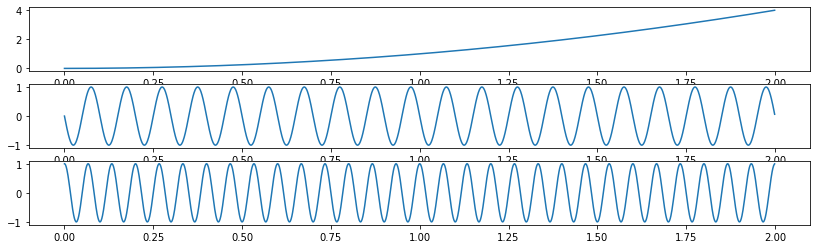

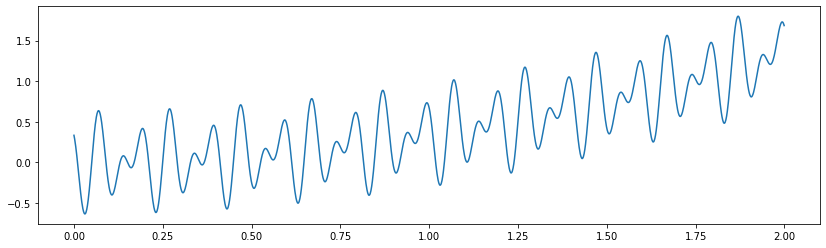

In [5]:
t = np.arange(0,2,0.001) # Tiempo (stat, stop, step)
r = np.array([1, 0, 0]) # ejes (x, y, z)
waves = make_data(t, r)
show_waves(waves, t)

In [6]:
df = pd.DataFrame(waves[-1][0], columns=['seq'], index=t).rename_axis("time")
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2000 entries, 0.0 to 1.999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


In [7]:
df.head()

,seq
time,
0.000,0.333333
0.001,0.310924
0.002,0.285653
0.003,0.257640
0.004,0.227034


## Scaler

In [8]:
scaler = MinMaxScaler()
seq_scaled = pd.Series(
    scaler.fit_transform(df).squeeze(),
    index=df.index)

In [9]:
df['seq_scaled'] = scaler.fit_transform(df['seq'].values.reshape(-1,1))
df.head()

,seq,seq_scaled
time,,
0.000,0.333333,0.397704
0.001,0.310924,0.388500
0.002,0.285653,0.378120
0.003,0.257640,0.366614
0.004,0.227034,0.354042


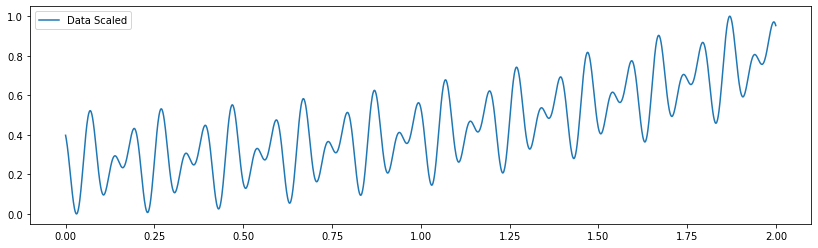

In [10]:
plt.figure("Data", figsize=(14, 4))
plt.plot(df['seq_scaled'], label="Data Scaled")
plt.legend()
plt.show()

## Get time series data into shape for an RNN
The input to every LSTM layer must have three dimensions, namely:

* **Batch size**: One sequence is one sample. A batch contains one or more samples.
* **Time steps**: One time step is a single observation in the sample.
* **Features**: One feature is one observation at a time step.

## Univariate rnn data

![Univariate_imagen](https://github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition/raw/d6e03d8a18809fd9a2dffc069a9f19038d6fa8a3/assets/timeseries_windowing.gif)

### Option 1 - manual

In [11]:
window_size = 15 # Or lookback
n_features = 1

In [12]:
def create_univariate_rnn_data(sequence, window_size, index, index_name=None, is_scaled=True):
    if is_scaled:
        columns=['X_scaled', 'y_scaled']
    else:
        columns=['X', 'y']
    df = pd.DataFrame(columns=columns, index=index[window_size:])
    df[columns[0]] = [sequence[i:i+window_size] for i in range(0, len(sequence)-window_size)]
    df[columns[1]] = np.array(sequence[window_size:])
    if index_name:
        df = df.rename_axis("time")
    return df

In [13]:
df_u_rnn = create_univariate_rnn_data(
    sequence=df['seq_scaled'].values , 
    window_size=window_size, 
    index=df.index.values,
    index_name="time")
df_u_rnn.head()

,X_scaled,y_scaled
time,,
0.015,"[0.3977044839741495, 0.3884999522790913, 0.378...",0.171470
0.016,"[0.3884999522790913, 0.37811973979924823, 0.36...",0.153818
0.017,"[0.37811973979924823, 0.36661377363439807, 0.3...",0.136547
0.018,"[0.36661377363439807, 0.35404230942767045, 0.3...",0.119787
0.019,"[0.35404230942767045, 0.34047556180633026, 0.3...",0.103669


In [47]:
np.stack(df_u_rnn['X_scaled'].values).shape

(1985, 15)

### Option 2 - TimeseriesGenerator

In [52]:
generator = TimeseriesGenerator(df['seq_scaled'].values, df['seq_scaled'].values, length=window_size, batch_size=1) 
# train_generator = TimeseriesGenerator(data_train, data_train, length=window_size, batch_size=1)     
# test_generator = TimeseriesGenerator(data_test, data_test, length=window_size, batch_size=1)

In [54]:
df_u_rnn_2 = pd.DataFrame(
    generator, 
    columns=['X_scaled', 'y_scaled'], 
    index=df.index.values[window_size:]
).rename_axis("time")

df_u_rnn_2.head()

,X_scaled,y_scaled
time,,
0.015,"[[0.3977044839741495, 0.3884999522790913, 0.37...",[0.1714702074633037]
0.016,"[[0.3884999522790913, 0.37811973979924823, 0.3...",[0.15381845871137856]
0.017,"[[0.37811973979924823, 0.36661377363439807, 0....",[0.13654690441888237]
0.018,"[[0.36661377363439807, 0.35404230942767045, 0....",[0.11978730476026206]
0.019,"[[0.35404230942767045, 0.34047556180633026, 0....",[0.10366921236592491]


In [55]:
np.stack(df_u_rnn_2['X_scaled'].values).shape

(1985, 1, 15)

## Train - Test

In [14]:
# 80% train 20% test
split_percent = 0.80
split = int(split_percent*len(df['seq_scaled']))
print(split)

1600


In [15]:
np.stack(df_u_rnn['X_scaled']).shape

(1985, 15)

In [16]:
# Data
train_scaled = df_u_rnn.iloc[:split]
test_scaled = df_u_rnn.iloc[split:]
X_train_scaled = np.stack(train_scaled['X_scaled']).reshape(-1, window_size, 1)
y_train_scaled = train_scaled['y_scaled'].values
X_test_scaled = np.stack(test_scaled['X_scaled']).reshape(-1, window_size, 1)
y_test_scaled = test_scaled['y_scaled'].values

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(1600, 15, 1)
(385, 15, 1)


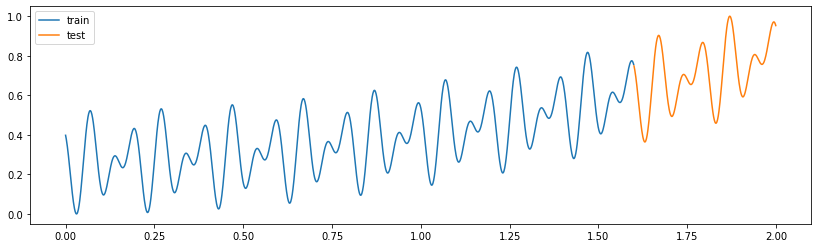

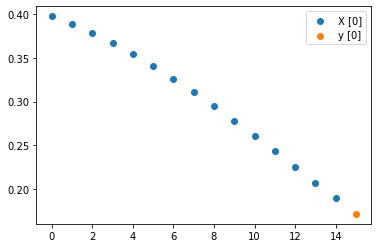

In [17]:
# Train - test
plt.figure("train-test", figsize=(14, 4))
plt.plot(seq_scaled.iloc[:split], label="train")
plt.plot(seq_scaled.iloc[split:], label="test")
plt.legend()
plt.show()
# X - y
plt.scatter(range(0,X_train_scaled[0].shape[0]), X_train_scaled[0], label="X [0]")
plt.scatter(X_train_scaled[0].shape[0], y_train_scaled[0], label="y [0]")
plt.legend()
plt.show()

## RNN

In [18]:
rnn = Sequential([
    LSTM(units=10,
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [19]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                        rho=0.9,
                                        epsilon=1e-08,
                                        decay=0.0)
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

## Train

In [21]:
lstm_training = rnn.fit(X_train_scaled,
                        y_train_scaled,
                        epochs=500,
                        batch_size=20,
                        validation_data=(X_test_scaled, y_test_scaled),
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/500
80/80 [==============================] - 7s 19ms/step - loss: 0.0377 - val_loss: 0.0183
Epoch 2/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0049 - val_loss: 0.0060
Epoch 3/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 4/500
80/80 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 5/500
80/80 [==============================] - 1s 12ms/step - loss: 5.6010e-04 - val_loss: 0.0011
Epoch 6/500
80/80 [==============================] - 1s 11ms/step - loss: 3.3200e-04 - val_loss: 0.0012
Epoch 7/500
80/80 [==============================] - 1s 11ms/step - loss: 3.2279e-04 - val_loss: 6.8475e-04
Epoch 8/500
80/80 [==============================] - 1s 11ms/step - loss: 2.4599e-04 - val_loss: 0.0016
Epoch 9/500
80/80 [==============================] - 1s 11ms/step - loss: 2.3910e-04 - val_loss: 3.2329e-04
Epoch 10/500
80/80 [==============================] - 1s 11ms/step - los

80/80 [==============================] - 1s 11ms/step - loss: 1.6997e-05 - val_loss: 8.3774e-05
Epoch 77/500
80/80 [==============================] - 1s 11ms/step - loss: 2.1499e-05 - val_loss: 1.5017e-04
Epoch 78/500
80/80 [==============================] - 1s 10ms/step - loss: 1.7487e-05 - val_loss: 6.0917e-06
Epoch 79/500
80/80 [==============================] - 1s 11ms/step - loss: 1.8173e-05 - val_loss: 6.6903e-06
Epoch 80/500
80/80 [==============================] - 1s 11ms/step - loss: 1.8058e-05 - val_loss: 8.7976e-05
Epoch 81/500
80/80 [==============================] - 1s 11ms/step - loss: 1.8106e-05 - val_loss: 6.3772e-06
Epoch 82/500
80/80 [==============================] - 1s 11ms/step - loss: 1.8220e-05 - val_loss: 8.2656e-05
Epoch 83/500
80/80 [==============================] - 1s 11ms/step - loss: 1.7570e-05 - val_loss: 1.0955e-04
Epoch 84/500
80/80 [==============================] - 1s 11ms/step - loss: 1.8945e-05 - val_loss: 5.6776e-06
Epoch 85/500
80/80 [============

Epoch 151/500
80/80 [==============================] - 1s 11ms/step - loss: 1.2762e-05 - val_loss: 6.8548e-06
Epoch 152/500
80/80 [==============================] - 1s 11ms/step - loss: 1.0820e-05 - val_loss: 1.2017e-04
Epoch 153/500
80/80 [==============================] - 1s 11ms/step - loss: 1.3041e-05 - val_loss: 2.4812e-05
Epoch 154/500
80/80 [==============================] - 1s 11ms/step - loss: 1.1607e-05 - val_loss: 2.4561e-05
Epoch 155/500
80/80 [==============================] - 1s 11ms/step - loss: 1.2832e-05 - val_loss: 3.9694e-06
Epoch 156/500
80/80 [==============================] - 1s 10ms/step - loss: 1.1272e-05 - val_loss: 6.2061e-05
Epoch 157/500
80/80 [==============================] - 1s 11ms/step - loss: 1.1979e-05 - val_loss: 3.1226e-06
Epoch 158/500
80/80 [==============================] - 1s 11ms/step - loss: 1.1937e-05 - val_loss: 3.6378e-06
Epoch 159/500
80/80 [==============================] - 1s 10ms/step - loss: 1.1842e-05 - val_loss: 4.6147e-06
Epoch 160/

80/80 [==============================] - 1s 13ms/step - loss: 9.7656e-06 - val_loss: 9.7481e-05
Epoch 226/500
80/80 [==============================] - 1s 14ms/step - loss: 1.0045e-05 - val_loss: 2.3015e-06
Epoch 227/500
80/80 [==============================] - 1s 14ms/step - loss: 9.7227e-06 - val_loss: 7.2226e-05
Epoch 228/500
80/80 [==============================] - 1s 12ms/step - loss: 9.2984e-06 - val_loss: 1.4688e-05
Epoch 229/500
80/80 [==============================] - 1s 14ms/step - loss: 9.9540e-06 - val_loss: 3.5635e-06
Epoch 230/500
80/80 [==============================] - 1s 13ms/step - loss: 9.3999e-06 - val_loss: 7.3554e-05
Epoch 231/500
80/80 [==============================] - 1s 12ms/step - loss: 1.0258e-05 - val_loss: 5.1534e-06
Epoch 232/500
80/80 [==============================] - 1s 12ms/step - loss: 8.5074e-06 - val_loss: 4.1133e-05
Epoch 233/500
80/80 [==============================] - 1s 12ms/step - loss: 1.0301e-05 - val_loss: 1.3435e-05
Epoch 234/500
80/80 [===

## Results

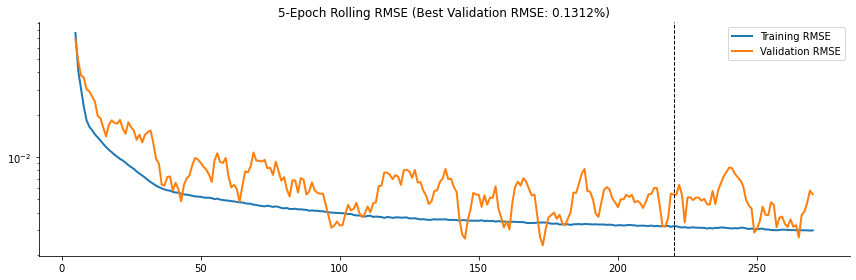

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [23]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train_scaled, y_train_scaled, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test_scaled, y_test_scaled, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0015 | Test RMSE: 0.0013


In [25]:
train_predict_scaled = rnn.predict(X_train_scaled)
test_predict_scaled = rnn.predict(X_test_scaled)

13/13 [==============================] - 0s 3ms/step


## Rescale predictions

In [24]:
y_train = scaler.inverse_transform(y_train_scaled.reshape(-1,1)).squeeze()
y_test = scaler.inverse_transform(y_test_scaled.reshape(-1,1)).squeeze()

In [26]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index = seq_scaled.index[:split])
test_predict = pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index = seq_scaled.index[split:-window_size])

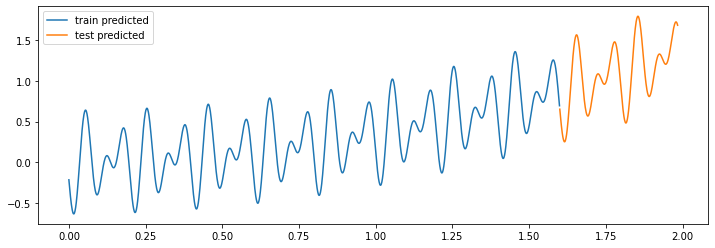

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(train_predict, label="train predicted")
plt.plot(test_predict, label="test predicted")
plt.legend()
plt.show()

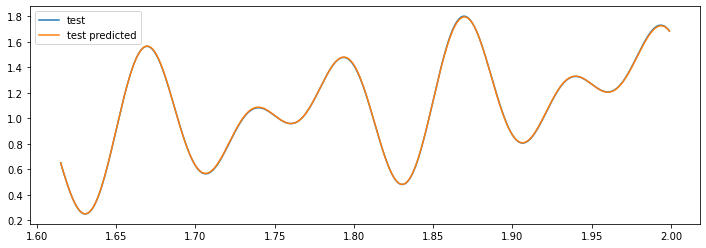

In [28]:
plt.figure(figsize=(12, 4))
plt.plot(seq_scaled.index[window_size+split:], y_test, label="test")
plt.plot(seq_scaled.index[window_size+split:], test_predict, label="test predicted")
plt.legend()
plt.show()